In [1]:
import cooler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#!!!
from lib.plots import set_axis, attach_colorbar

In [2]:
def mask_tri(matrix: np.ndarray, which: str, k: int = 0) -> np.ma.masked_array:
    mask = np.ones(matrix.shape, dtype=bool)
    if which == "lower":
        mask = np.tril(mask, k)
    if which == "upper":
        mask = np.triu(mask, k)
    return np.ma.masked_array(matrix, mask)


def format_mb(x: float, pos: int) -> str:
    return "{:g}".format(x / 1e6)

---

In [3]:
sim_filename = "sim.cool"
exp_filename = "4DNFIXP4QG5B.mcool::/resolutions/100000"

cool_sim = cooler.Cooler(sim_filename)
cool_exp = cooler.Cooler(exp_filename)

In [4]:
pc1_sim_table = pd.read_csv("pc1-sim.tsv", sep="\t")
pc1_exp_table = pd.read_csv("pc1-exp.tsv", sep="\t")

In [5]:
chrom = "chr11"

slice_sim = slice(*cool_sim.extent((chrom, None, None)))
slice_exp = slice(*cool_exp.extent((chrom, None, None)))
matrix_sim = cool_sim.matrix(balance=True)[slice_sim, slice_sim]
matrix_exp = cool_exp.matrix(balance=True)[slice_exp, slice_exp]

pc1_sim_section = pc1_sim_table.query("chrom == @chrom")
pc1_exp_section = pc1_exp_table.query("chrom == @chrom")
pc1_sim = pc1_sim_section["pc1"].values / pc1_sim_table["pc1"].std()
pc1_exp = pc1_exp_section["pc1"].values / pc1_exp_table["pc1"].std()

In [6]:
bins_sim = cool_sim.bins()[:]
bins_exp = cool_exp.bins()[:]
chrom_sizes = cool_sim.chromsizes.to_dict()

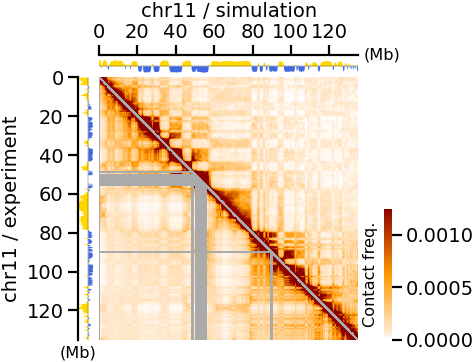

In [8]:
qmax = 95
vmax = max(
    np.nanpercentile(matrix_sim, q=qmax),
    np.nanpercentile(matrix_sim, q=qmax),
)
chrom_size = chrom_sizes[chrom]

matshow_style = dict(
    extent=[0, chrom_size, chrom_size, 0],
    vmin=0,
    vmax=vmax,
    cmap="wrr",
    interpolation="kaiser",
    aspect="auto",
    rasterized=True,
)

sm = mpl.cm.ScalarMappable(
    norm=mpl.colors.Normalize(matshow_style["vmin"], matshow_style["vmax"]),
    cmap=matshow_style["cmap"],
)

tick_formatter = mpl.ticker.FuncFormatter(format_mb)
tick_unit = "(Mb)"
tick_unit_style = dict(fontsize="small")

# Plot contact matrices side-by-side.
fig = plt.figure(figsize=(2.2, 2.0), layout="tight")
grid = plt.GridSpec(
    2, 2, figure=fig, width_ratios=[1, 12], height_ratios=[1, 12], wspace=0, hspace=0,
)

ax_matrix = fig.add_subplot(grid[1, 1])
ax_x = fig.add_subplot(grid[0, 1], sharex=ax_matrix)
ax_y = fig.add_subplot(grid[1, 0], sharey=ax_matrix)

# Contact matrix
ax_matrix.matshow(mask_tri(matrix_sim, "lower"), **matshow_style)
ax_matrix.matshow(mask_tri(matrix_exp, "upper"), **matshow_style)
ax_matrix.patch.set_facecolor("#aaa")

cbar = attach_colorbar(ax_matrix, sm, size=0.03, margin=0.1)
cbar.outline.set_edgecolor("none")
cbar.set_label("Contact freq.", fontsize="small")
cbar.ax.yaxis.set_label_position("left")

# 
pc1_max = 2.5

x = pc1_sim_section["start"].values
y = pc1_sim
ax_x.fill_between(x, y, where=(y > 0), fc="gold", interpolate=True, zorder=1)
ax_x.fill_between(x, y, where=(y < 0), fc="royalblue", interpolate=True, zorder=1)
ax_x.axhline(0, lw=0.1, zorder=2)
ax_x.set_ylim(-pc1_max, pc1_max)

x = pc1_exp_section["start"].values
y = pc1_exp
ax_y.fill_betweenx(x, y, where=(y > 0), fc="gold", interpolate=True, zorder=1)
ax_y.fill_betweenx(x, y, where=(y < 0), fc="royalblue", interpolate=True, zorder=1)
ax_y.axvline(0, lw=0.1, zorder=2)
ax_y.set_xlim(pc1_max, -pc1_max) # invert axis to make plot symmetric with pc1_sim

# Ticks
ax_x.text(1.02, 1, tick_unit, **tick_unit_style, ha="left", va="center", transform=ax_x.transAxes)
ax_y.text(0, -0.02, tick_unit, **tick_unit_style, ha="center", va="top", transform=ax_y.transAxes)

ax_x.xaxis.set_major_formatter(tick_formatter)
ax_y.yaxis.set_major_formatter(tick_formatter)
ax_x.xaxis.set_label_position("top")
ax_y.yaxis.set_label_position("left")
ax_x.set_xlabel(f"{chrom} / simulation")
ax_y.set_ylabel(f"{chrom} / experiment")

set_axis(ax_x, "top")
set_axis(ax_y, "left")
set_axis(ax_matrix, "none")

# fig.savefig("ContactMap.svg")

pass